In [1]:
# evaluate the posterior on a set of points that are known to be the same 

# todo per nishad's suggestion

In [2]:
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import numpy as np
import os
import trimesh
import b3d
from jax.scipy.spatial.transform import Rotation as Rot
from b3d import Pose
import rerun as rr
import genjax
from tqdm import tqdm
from  matplotlib.colors import LinearSegmentedColormap

from b3d.utils import unproject_depth


rr.init("demo.py")
rr.connect("127.0.0.1:8812")

In [3]:
width=512
height=512
fx=256.0
fy=256.0
cx=256.0
cy=256.0
near=0.001
far=16.0
renderer = b3d.Renderer(
    width, height, fx, fy, cx, cy, near, far
)

grid_dim = 10
num_frames = grid_dim * grid_dim

from b3d.pose import from_axis_angle

r_mat = from_axis_angle(jnp.array([0,0,1]), jnp.pi/2)

vec_transform_axis_angle = jax.vmap(from_axis_angle, (None, 0))
#rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(-4*jnp.pi/8, -4*jnp.pi/8, num_frames)) 
rots = vec_transform_axis_angle(jnp.array([0,0,1]), jnp.linspace(-5*jnp.pi/8, -5*jnp.pi/8, num_frames)) 


# need to fix rotation to static

object_library = b3d.MeshLibrary.make_empty_library()
occluder = trimesh.creation.box(extents=jnp.array([0.001, 0.2, 0.2]))
occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)


cam_inv_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.15, 0.15, 0.0]),
    jnp.array([0.0, 0.0, 0.0])
).inv()


in_place_rots = rots


compound_pose = cam_inv_pose @ in_place_rots #in_place_rot


rgbs, depths = renderer.render_attribute_many(
    compound_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)

unproject_depth_vec = jax.vmap(unproject_depth, (0, None))
xyzs = unproject_depth_vec(depths, renderer)

Text(0.5, 1.0, 'Rendered Color')

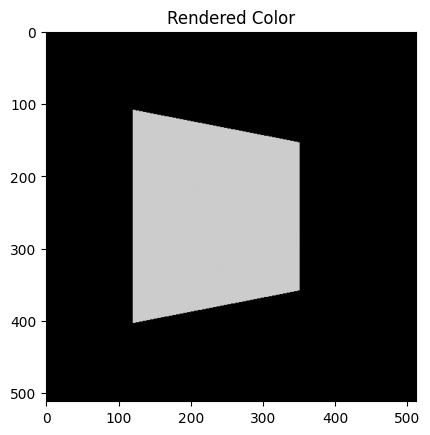

In [4]:
plt.imshow(rgbs[0])
plt.title('Rendered Color')

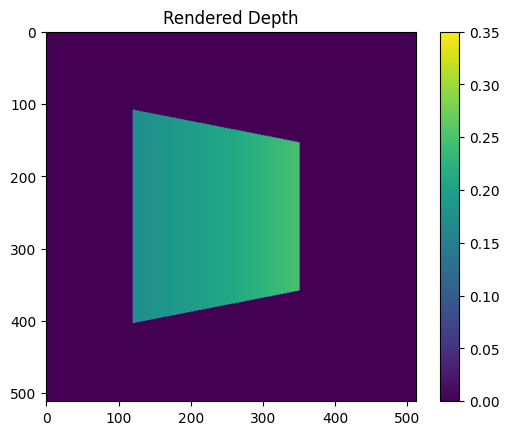

In [5]:
#cmap=LinearSegmentedColormap.from_list('kw',["k", "w"], N=256) 
plt.imshow(depths[0], vmin=0, vmax=0.35)
plt.title('Rendered Depth')
plt.colorbar()

In [6]:
rr.log("/cloud/"+str(0), rr.Points3D(xyzs[0].reshape(-1,3), colors=rgbs[0].reshape(-1,3)))

In [7]:
object_library = b3d.MeshLibrary.make_empty_library()

# need to introduce additional translations in pose
occluder = trimesh.creation.box(extents=jnp.array([0.001, 0.075, 0.075]))
occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)

In [8]:
net_pose = compound_pose

rgbs, depths = renderer.render_attribute_many(
    net_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)

unproject_depth_vec = jax.vmap(unproject_depth, (0, None))
xyzs = unproject_depth_vec(depths, renderer)

In [9]:
delta = 0.05 
# grid_dim = 15

one_grid  = jax.vmap(lambda p: Pose.from_translation(p))(jnp.stack(
        jnp.meshgrid(
            jnp.linspace(-0, 0, 1),
            jnp.linspace(-delta, delta, grid_dim),
            jnp.linspace(-delta, delta, grid_dim),
        ),
        axis=-1,
    ).reshape(-1, 3))

In [10]:
net_pose = compound_pose @ one_grid

rgbs, depths = renderer.render_attribute_many(
    net_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)

unproject_depth_vec = jax.vmap(unproject_depth, (0, None))
xyzs = unproject_depth_vec(depths, renderer)

In [11]:
for i in range(25):
    rr.log("/patch_cloud/"+str(i), rr.Points3D(xyzs[i][xyzs[i,...,2]<16], colors=rgbs[i][xyzs[i,...,2]<16]))

In [12]:
xyzs[i][xyzs[i,...,2]<16].shape

(6680, 3)

In [13]:
#color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.01))
color_error, depth_error = (jnp.float32(30.0), jnp.float32(0.01))
# TODO: explain
inlier_score, outlier_prob = (jnp.float32(50.0), jnp.float32(0.001)) # 5
# TODO: explain
#color_multiplier, depth_multiplier = (jnp.float32(3000.0), jnp.float32(3000.0))
color_multiplier, depth_multiplier = (jnp.float32(30.0), jnp.float32(30.0))


model_args = b3d.model.ModelArgs(color_error, depth_error,
                            inlier_score, outlier_prob,
                            color_multiplier, depth_multiplier)



In [14]:
rgbs, depths = renderer.render_attribute_many(
    net_pose[:,None,...],
    object_library.vertices,
    object_library.faces,
    jnp.array([[0, len(object_library.faces)]]),
    object_library.attributes
)

unproject_depth_vec = jax.vmap(unproject_depth, (0, None))
xyzs = unproject_depth_vec(depths, renderer)

model = b3d.model_multiobject_gl_factory(renderer)
importance_jit = jax.jit(model.importance)

key = jax.random.PRNGKey(0)


trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", compound_pose[0]),
            ("object_0", 0),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(1),model_args, object_library)
)

trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[0],xyzs[0,...,2])
    )


poses, grid_scores = b3d.enumerate_and_return_scores(trace, genjax.Pytree.const(["object_pose_0"]), key, one_grid[None,...])


In [15]:
unit_scores = (grid_scores - jnp.min(grid_scores))/jnp.max(grid_scores - jnp.min(grid_scores))

In [16]:
rr.log('score_dots',rr.Points3D(poses.pos, colors = np.outer(np.round(255*unit_scores), np.array([1,0,0])).astype(int), radii=0.01))

In [17]:
cmap=LinearSegmentedColormap.from_list('kr',["k", "r"], N=256) 

In [18]:
grid_scores

Array([29.939554, 29.68242 , 29.422785, 29.16102 , 28.897032, 28.630377,
       28.361605, 28.157774, 28.157774, 28.158125, 29.666273, 29.442469,
       29.216368, 28.98783 , 28.757772, 28.526548, 28.29318 , 28.115595,
       28.114775, 28.114187, 29.366896, 29.178919, 28.99048 , 28.798613,
       28.60639 , 28.413084, 28.218401, 28.070768, 28.069242, 28.06936 ,
       29.068941, 28.9159  , 28.76402 , 28.609251, 28.45436 , 28.29931 ,
       28.143236, 28.02423 , 28.022818, 28.023405, 28.753115, 28.639608,
       28.527472, 28.41453 , 28.300447, 28.186796, 28.071817, 27.985392,
       27.984568, 27.985273, 28.417807, 28.343729, 28.272795, 28.199896,
       28.126406, 28.053179, 27.979944, 27.923853, 27.922083, 27.923384,
       28.08167 , 28.047293, 28.017302, 27.984102, 27.951101, 27.918344,
       27.88555 , 27.860537, 27.85758 , 27.859354, 27.80348 , 27.80182 ,
       27.804785, 27.804785, 27.804785, 27.804785, 27.804785, 27.804785,
       27.80182 , 27.80348 , 27.734919, 27.73195 , 

Text(0, 0.5, 'y-axis posterior grid offset')

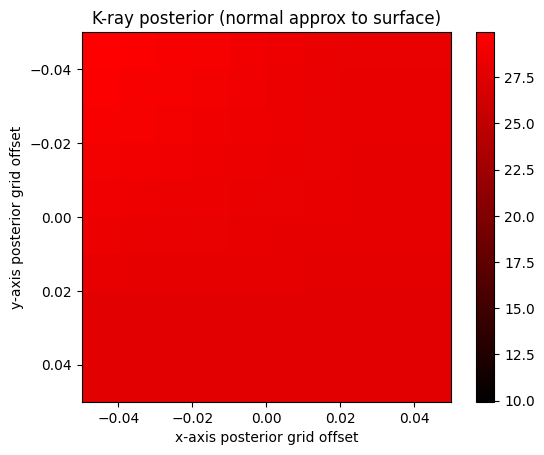

In [19]:
plt.imshow(grid_scores.reshape(grid_dim, grid_dim), cmap=cmap, extent=[-delta,delta,delta,-delta], vmin=jnp.max(grid_scores)-20, vmax=jnp.max(grid_scores))
plt.colorbar()
# plt.title('K-ray posterior (uniform on pixels)')
plt.title('K-ray posterior (normal approx to surface)')

plt.xlabel('x-axis posterior grid offset')
plt.ylabel('y-axis posterior grid offset')

In [20]:
jnp.min(grid_scores)

Array(27.6587, dtype=float32)

In [21]:
d_im = (depths[0] / fx) * (depths[0] / fy)
area_flat = (d_im).sum()
area_flat

Array(0.00478622, dtype=float32)

In [22]:
d_im = (depths[90] / fx) * (depths[90] / fy)
area_flat = (d_im).sum()
area_flat

Array(0.00568185, dtype=float32)

In [23]:
depths[90].sum()

Array(1941.3635, dtype=float32)

In [24]:
depths[0].sum()

Array(1363.1859, dtype=float32)

Text(0.5, 1.0, 'Rendered Color')

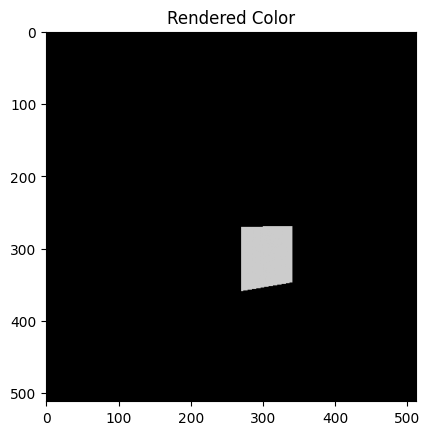

In [25]:
plt.imshow(rgbs[0])
plt.title('Rendered Color')

Text(0.5, 1.0, 'Rendered Color')

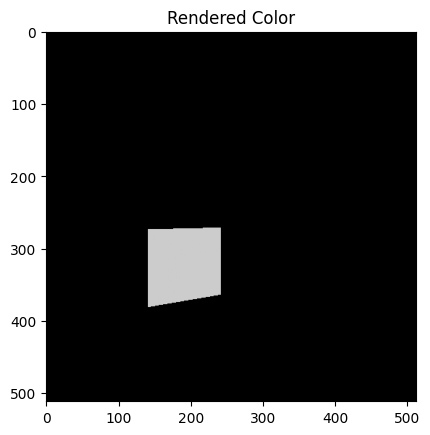

In [26]:
plt.imshow(rgbs[90])
plt.title('Rendered Color')

Text(0.5, 1.0, 'Rendered Depth')

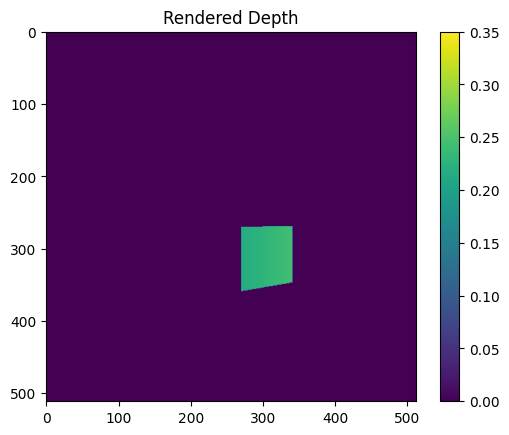

In [27]:
plt.imshow(depths[0], vmin=0, vmax=0.35)
plt.colorbar()
plt.title('Rendered Depth')

Text(0.5, 1.0, 'Rendered Depth')

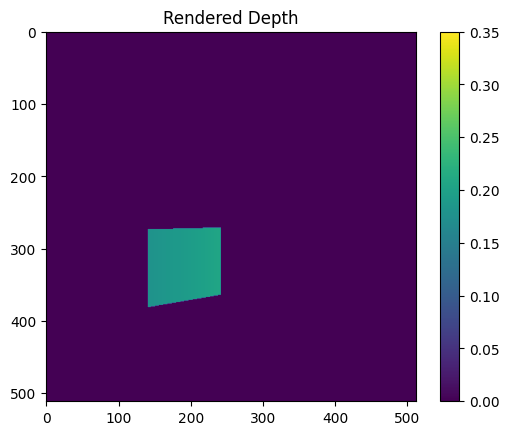

In [28]:
plt.imshow(depths[90], vmin=0, vmax=0.35)
plt.colorbar()
plt.title('Rendered Depth')

In [29]:
from b3d.model import rgbd_sensor_model_surfacenorm


model = b3d.model_multiobject_gl_factory_normal(renderer, rgbd_sensor_model_surfacenorm)
importance_jit = jax.jit(model.importance)

key = jax.random.PRNGKey(0)


trace, _ = importance_jit(
    jax.random.PRNGKey(0),
    genjax.choice_map(
        dict([
            ("camera_pose", Pose.identity()),
            ("object_pose_0", compound_pose[0]),
            ("object_0", 0),
            ("observed_rgb_depth", (rgbs[0], xyzs[0,...,2])),
        ])
    ),
    (jnp.arange(1),model_args, object_library)
)

trace = b3d.update_choices_jit(trace, key,
        genjax.Pytree.const(["observed_rgb_depth"]),
        (rgbs[0],xyzs[0,...,2])
    )


poses, grid_scores = b3d.enumerate_and_return_scores(trace, genjax.Pytree.const(["object_pose_0"]), key, one_grid[None,...])

Text(0, 0.5, 'y-axis posterior grid offset')

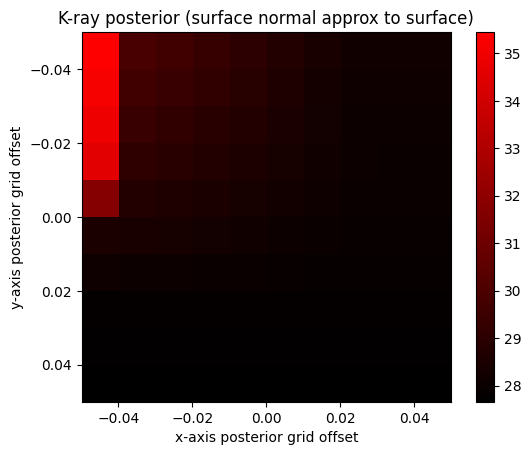

In [30]:
plt.imshow(grid_scores.reshape(grid_dim, grid_dim), cmap=cmap, extent=[-delta,delta,delta,-delta])
plt.colorbar()
plt.title('K-ray posterior (surface normal approx to surface)')

plt.xlabel('x-axis posterior grid offset')
plt.ylabel('y-axis posterior grid offset')

In [31]:
# debug this and get it written up for tomorrow

In [32]:
# varying posterior patch

In [33]:
# surface normal corrected here

In [34]:
#d / f_x assumption is wrong

In [35]:
# make a perpendicular flat grid here

In [77]:

# def test_distance_to_camera_invarance(renderer):

mesh_path = os.path.join(
    b3d.get_root_path(), "assets/shared_data_bucket/025_mug/textured.obj"
)
mesh = trimesh.load(mesh_path)
mesh.vertices = mesh.vertices - mesh.vertices.mean(axis=0)
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_trimesh(mesh)


object_library = b3d.MeshLibrary.make_empty_library()
occluder = trimesh.creation.box(extents=jnp.array([0.15, 0.1, 0.1]))
occluder_colors = jnp.tile(jnp.array([0.8, 0.8, 0.8])[None,...], (occluder.vertices.shape[0], 1))
object_library = b3d.MeshLibrary.make_empty_library()
object_library.add_object(occluder.vertices, occluder.faces, attributes=occluder_colors)

image_width = 200
image_height = 200
fx = 200.0
fy = 200.0
cx = 100.0
cy = 100.0
near = 0.001
far = 16.0
renderer.set_intrinsics(image_width, image_height, fx, fy, cx, cy, near, far)

near_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.3, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0])
).inv()

far_pose = b3d.Pose.from_position_and_target(
    jnp.array([0.9, 0.0, 0.0]), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0])
).inv()

min_distance = 0.3
max_distance = 0.9
num_distances = 50
pos_target_map = jax.vmap(b3d.Pose.from_position_and_target, (0, None, None))
poses = pos_target_map(jnp.linspace(jnp.array([min_distance, 0.0, 0.0]), jnp.array([max_distance, 0.0, 0.0]), num_distances), jnp.array([0.0, 0.0, 0.0]), jnp.array([0.0, 0.0, 1.0]))
poses=poses.inv()

rgbs, depths = renderer.render_attribute_many(
    poses[:,None,...],
    object_library.vertices,
    object_library.faces,
    object_library.ranges,
    object_library.attributes,
)


color_error, depth_error = (50.0, 0.01)
inlier_score, outlier_prob = (4.0, 0.000001)
color_multiplier, depth_multiplier = (100.0, 1.0)
model_args = b3d.ModelArgs(
    color_error,
    depth_error,
    inlier_score,
    outlier_prob,
    color_multiplier,
    depth_multiplier,
)

from genjax.generative_functions.distributions import ExactDensity
import genjax


rr.log("img_near", rr.Image(rgbs[0]))
rr.log("img_far", rr.Image(rgbs[-1]))



area_near = ((depths[0] / fx) * (depths[0]  / fy)).sum()
area_far = ((depths[-1]  / fx) * (depths[-1]  / fy)).sum()
print(area_near, area_far)

near_score = (
    b3d.rgbd_sensor_model.logpdf(
        (rgbs[0] , depths[0] ), rgbs[0], depths[0] , model_args, fx, fy, 0.0
    )
)

far_score = (
    b3d.rgbd_sensor_model.logpdf(
        (rgbs[-1] , depths[-1] ), rgbs[-1], depths[-1], model_args, fx, fy, 0.0
    )
)
print(near_score, far_score)
print(b3d.normalize_log_scores(jnp.array([near_score, far_score])))



0.010025018 0.010634765
-321.63773 -315.73328
[0.00271989 0.9972876 ]


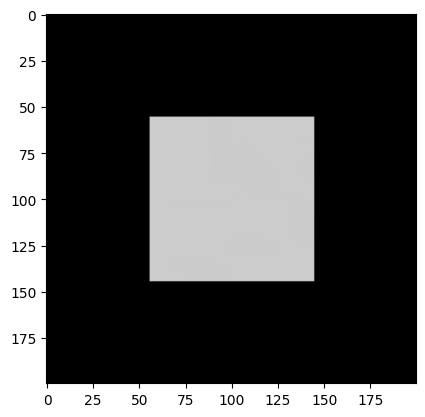

In [78]:
plt.imshow(rgbs[0])

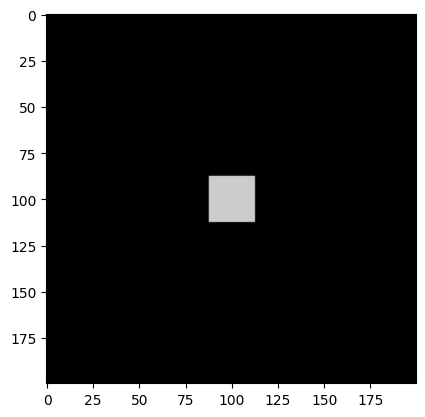

In [79]:
plt.imshow(rgbs[-1])

In [80]:
scores = []
for i in range(len(rgbs)):
    score = (
        b3d.rgbd_sensor_model.logpdf(
            (rgbs[i] , depths[i] ), rgbs[i], depths[i], model_args, fx, fy, 0.0
        )
    )
    scores.append(score)

In [81]:
jnp.array(scores)

Array([-321.63773, -320.23624, -319.81165, -320.3577 , -321.88248,
       -324.4085 , -321.91312, -319.9329 , -324.90512, -324.1297 ,
       -323.8513 , -324.0678 , -324.78088, -318.30255, -319.72076,
       -321.63773, -324.0678 , -318.3326 , -321.45438, -325.1228 ,
       -319.84198, -324.22263, -319.20667, -324.31558, -319.53915,
       -325.40298, -320.84442, -321.8672 , -323.1415 , -318.8747 ,
       -326.4651 , -322.37286, -318.3627 , -326.93546, -323.07993,
       -319.2973 , -315.58487, -325.2784 , -321.6989 , -318.1823 ,
       -329.01834, -325.62122, -322.28082, -318.99536, -315.76294,
       -327.97418, -324.843  , -321.76007, -318.72397, -315.73328],      dtype=float32)

Text(0, 0.5, 'pixels')

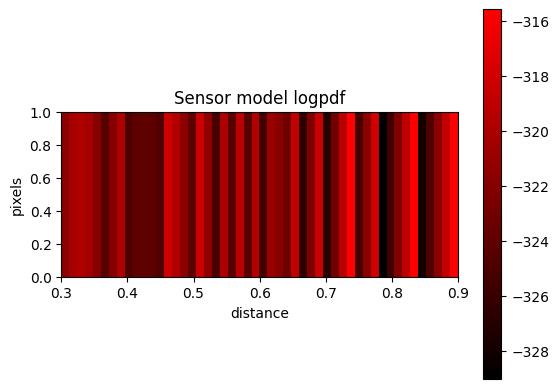

In [89]:
plt.imshow(jnp.array(scores)[None,...],cmap=cmap, extent=[min_distance,max_distance,0,1], aspect=0.25)
plt.colorbar()
plt.title('Sensor model logpdf')
plt.xlabel('distance')
plt.ylabel('pixels')

In [70]:
max_distance

0.9

In [53]:
plt.gca

<function matplotlib.pyplot.gca() -> 'Axes'>

In [41]:
# need to do this interpolation
# move surface progressively farther from the plane